In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import random
from Bio import SeqIO

In [4]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [5]:
def get_input_for_embedding(fasta_file):
    encodings = []
    
    # define universe of possible input values
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    
    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        data = seq_record.seq
        for char in data:
            if char not in alphabet:
                return
        integer_encoded = [char_to_int[char] for char in data]
        encodings.append(integer_encoded)
    encodings = np.array(encodings)
    return encodings

In [6]:
def create_sequence_model():
    """Create CNN model for sequence data"""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(33,)),
        tf.keras.layers.Embedding(21, 21, input_length=33),
        tf.keras.layers.Reshape((33, 21, 1)),
        tf.keras.layers.Conv2D(32, kernel_size=(17, 3), activation='relu', padding='valid'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [10]:
def train_and_evaluate(train_pos_data, train_neg_data, test_pos_data, test_neg_data):
    # Combine and create labels
    X_train = np.concatenate([train_pos_data, train_neg_data])
    y_train = np.concatenate([np.ones(len(train_pos_data)), np.zeros(len(train_neg_data))])
    
    X_test = np.concatenate([test_pos_data, test_neg_data])
    y_test = np.concatenate([np.ones(len(test_pos_data)), np.zeros(len(test_neg_data))])
    
    # Shuffle training data
    train_indices = np.arange(len(X_train))
    np.random.shuffle(train_indices)
    X_train = X_train[train_indices]
    y_train = y_train[train_indices]
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Training labels shape: {y_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    print(f"Test labels shape: {y_test.shape}")
    print(f"Distribution of training labels: {np.bincount(y_train.astype(int))}")
    print(f"Distribution of test labels: {np.bincount(y_test.astype(int))}")
    
    # Initialize cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    
    # Initialize metrics storage
    metrics = {'acc': [], 'mcc': [], 'sn': [], 'sp': []}
    test_predictions = []
    
    # Cross-validation loop
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train), 1):
        print(f"\nFold {fold}/5")
        
        # Create callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        )
        
        # Create and compile model
        model = create_sequence_model()
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Train model
        print("Training model...")
        history = model.fit(
            X_train[train_idx], y_train[train_idx],
            batch_size=32,
            epochs=50,
            validation_data=(X_train[val_idx], y_train[val_idx]),
            callbacks=[early_stopping],
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy - Fold {fold}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        # plt.savefig(f'accuracy_fold_{fold}.png')
        # plt.close()
        
        # Evaluate on validation set
        y_pred = model.predict(X_train[val_idx])
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate metrics
        cm = confusion_matrix(y_train[val_idx], y_pred_binary)
        metrics['acc'].append(accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['mcc'].append(matthews_corrcoef(y_train[val_idx], y_pred_binary))
        metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))
        metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))
        
        # Predict on test set
        test_pred = model.predict(X_test)
        test_predictions.append(test_pred)
        
        print(f"\nFold {fold} Results:")
        print(f"Accuracy: {metrics['acc'][-1]:.4f}")
        print(f"MCC: {metrics['mcc'][-1]:.4f}")
        print(f"Sensitivity: {metrics['sn'][-1]:.4f}")
        print(f"Specificity: {metrics['sp'][-1]:.4f}")
    
    # Print average cross-validation results
    print("\nAverage Cross-validation Results:")
    for metric in metrics:
        print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
    
    # Ensemble predictions on test set
    test_pred_avg = np.mean(test_predictions, axis=0)
    test_pred_binary = (test_pred_avg > 0.5).astype(int)
    
    # Calculate final test metrics
    cm_test = confusion_matrix(y_test, test_pred_binary)
    print("\nFinal Test Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, test_pred_binary):.4f}")
    print(f"Sensitivity: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):.4f}")
    print(f"Specificity: {cm_test[0][0]/(cm_test[0][0]+cm_test[0][1]):.4f}")
    print("Confusion Matrix:")
    print(cm_test)
    
    return model

Loading and encoding sequences...

Starting training and evaluation...
Training data shape: (9497, 33)
Training labels shape: (9497,)
Test data shape: (3224, 33)
Test labels shape: (3224,)

Fold 1/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-11-26 20:56:15.434482: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-11-26 20:56:15.434514: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-26 20:56:15.434526: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-26 20:56:15.434542: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-26 20:56:15.434552: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Training model...
Epoch 1/50


2024-11-26 20:56:16.606378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


238/238 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5115 - loss: 0.6916 - val_accuracy: 0.6621 - val_loss: 0.6435
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6562 - loss: 0.6232 - val_accuracy: 0.7184 - val_loss: 0.5811
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7176 - loss: 0.5618 - val_accuracy: 0.7332 - val_loss: 0.5518
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7445 - loss: 0.5247 - val_accuracy: 0.7474 - val_loss: 0.5324
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7582 - loss: 0.5054 - val_accuracy: 0.7463 - val_loss: 0.5317
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7660 - loss: 0.4927 - val_accuracy: 0.7521 - val_loss: 0.5272
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7666 - loss: 0.4829 - val_accuracy: 0.7605 - val_loss: 0.5220
Epoch 8/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7765 - loss: 0.4690 - val_accuracy: 0.754

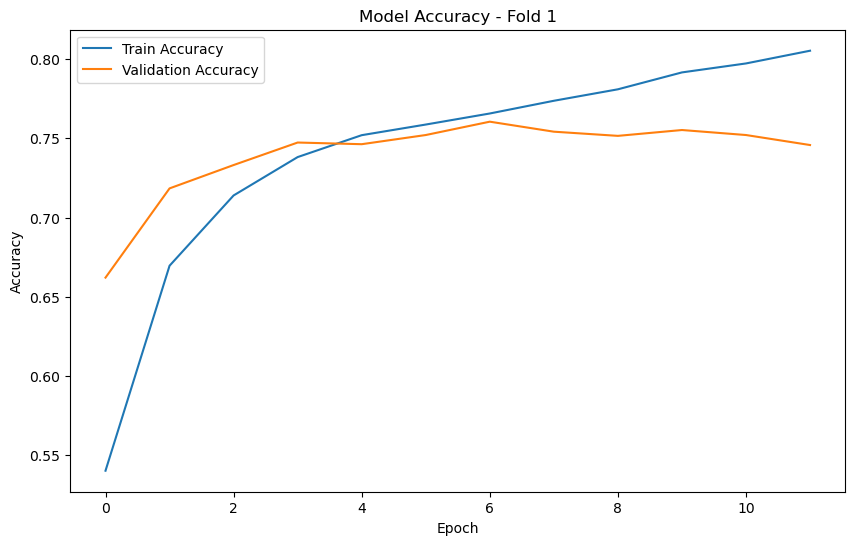

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 1 Results:
Accuracy: 0.7605
MCC: 0.5234
Sensitivity: 0.8199
Specificity: 0.6991

Fold 2/5
Training model...
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5290 - loss: 0.6912 - val_accuracy: 0.6684 - val_loss: 0.6416
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6388 - loss: 0.6296 - val_accuracy: 0.7274 - val_loss: 0.5697
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7139 - loss: 0.5590 - val_accuracy: 0.7421 - val_loss: 0.5409
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7331 - loss: 0.5310 - val_accuracy: 0.7442 - val_loss: 0.5306
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7506 - loss: 0.5189 - val_accuracy: 0.7384 - val_loss: 0.5255
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7569 - loss: 0.4966 - val_accuracy: 0.7463 - val_loss: 0.5215
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7697 - loss: 0.4910 - val_accuracy: 0.7400 - val_loss: 0.5248
Epoch 8/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7845 - loss: 0.4744 - val_accuracy: 0.741

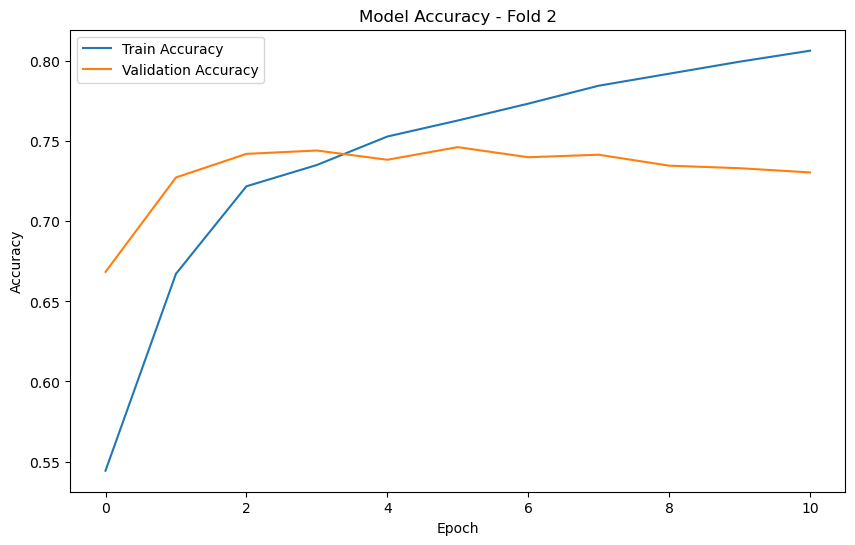

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 2 Results:
Accuracy: 0.7463
MCC: 0.5012
Sensitivity: 0.8574
Specificity: 0.6292

Fold 3/5
Training model...
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5401 - loss: 0.6885 - val_accuracy: 0.6403 - val_loss: 0.6472
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6578 - loss: 0.6296 - val_accuracy: 0.6872 - val_loss: 0.6061
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7010 - loss: 0.5789 - val_accuracy: 0.7141 - val_loss: 0.5586
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7326 - loss: 0.5494 - val_accuracy: 0.7209 - val_loss: 0.5389
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7476 - loss: 0.5258 - val_accuracy: 0.7372 - val_loss: 0.5320
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7623 - loss: 0.5010 - val_accuracy: 0.7399 - val_loss: 0.5254
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7622 - loss: 0.4947 - val_accuracy: 0.7404 - val_loss: 0.5240
Epoch 8/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7789 - loss: 0.4792 - val_accuracy: 0.740

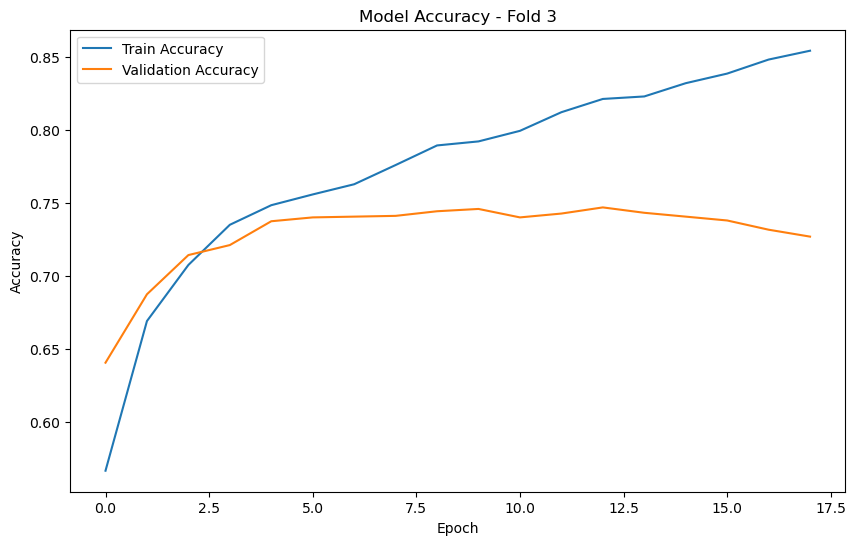

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 3 Results:
Accuracy: 0.7467
MCC: 0.4942
Sensitivity: 0.7619
Specificity: 0.7329

Fold 4/5
Training model...
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5195 - loss: 0.6922 - val_accuracy: 0.6261 - val_loss: 0.6481
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6473 - loss: 0.6300 - val_accuracy: 0.7062 - val_loss: 0.5783
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6987 - loss: 0.5749 - val_accuracy: 0.7293 - val_loss: 0.5517
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7318 - loss: 0.5487 - val_accuracy: 0.7346 - val_loss: 0.5387
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7426 - loss: 0.5291 - val_accuracy: 0.7367 - val_loss: 0.5326
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7533 - loss: 0.5179 - val_accuracy: 0.7372 - val_loss: 0.5259
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7662 - loss: 0.4995 - val_accuracy: 0.7414 - val_loss: 0.5245
Epoch 8/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7711 - loss: 0.4915 - val_accuracy: 0.740

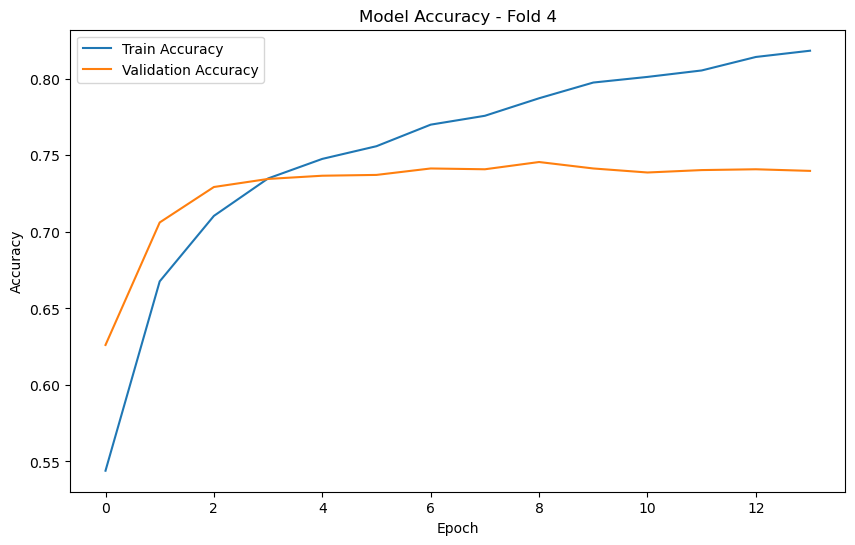

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 4 Results:
Accuracy: 0.7457
MCC: 0.4907
Sensitivity: 0.7738
Specificity: 0.7158

Fold 5/5
Training model...
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5288 - loss: 0.6884 - val_accuracy: 0.6335 - val_loss: 0.6369
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6550 - loss: 0.6138 - val_accuracy: 0.6956 - val_loss: 0.5675
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7235 - loss: 0.5526 - val_accuracy: 0.7225 - val_loss: 0.5408
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7366 - loss: 0.5281 - val_accuracy: 0.7267 - val_loss: 0.5338
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7485 - loss: 0.5115 - val_accuracy: 0.7414 - val_loss: 0.5227
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7606 - loss: 0.4990 - val_accuracy: 0.7267 - val_loss: 0.5229
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7656 - loss: 0.4857 - val_accuracy: 0.7362 - val_loss: 0.5170
Epoch 8/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7812 - loss: 0.4733 - val_accuracy: 0.734

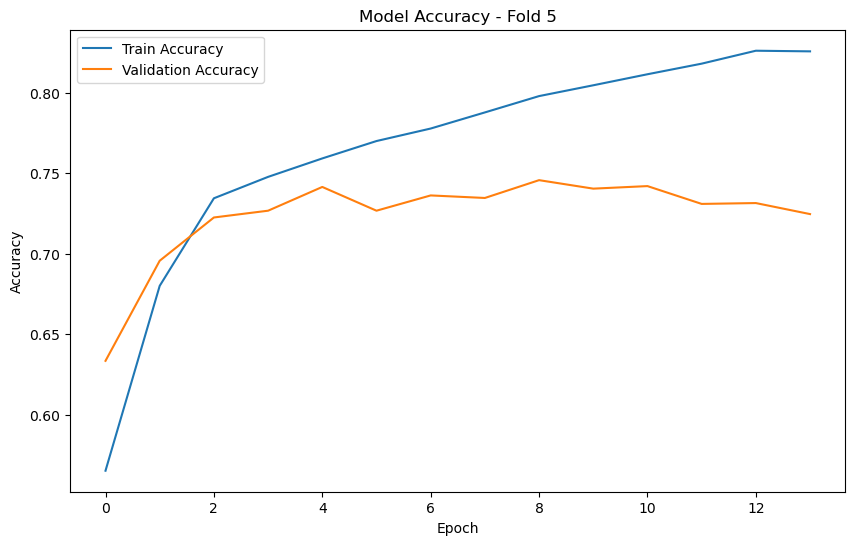

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 5 Results:
Accuracy: 0.7457
MCC: 0.4910
Sensitivity: 0.7103
Specificity: 0.7793

Average Cross-validation Results:
ACC: 0.7490 ± 0.0058
MCC: 0.5001 ± 0.0122
SN: 0.7846 ± 0.0504
SP: 0.7113 ± 0.0490

Final Test Set Results:
Accuracy: 0.7122
MCC: 0.2868
Sensitivity: 0.7984
Specificity: 0.7048
Confusion Matrix:
[[2094  877]
 [  51  202]]


In [9]:
if __name__ == "__main__":
    print("Loading and encoding sequences...")
    
    # Load and encode sequences
    test_positive_embedding = get_input_for_embedding('../../data/test/fasta/test_positive_sites.fasta')
    test_negative_embedding = get_input_for_embedding('../../data/test/fasta/test_negative_sites.fasta')
    train_positive_embedding = get_input_for_embedding('../../data/train/fasta/positive_sites.fasta')
    train_negative_embedding = get_input_for_embedding('../../data/train/fasta/negative_sites.fasta')
    
    # Train and evaluate model
    print("\nStarting training and evaluation...")
    model = train_and_evaluate(train_positive_embedding, train_negative_embedding, 
                             test_positive_embedding, test_negative_embedding)